In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git
#!pip install image_slicer

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow as tf
import numpy as np
import cv2
import time
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import randint
import random
import io
from PIL import Image
from tensorflow.keras import backend as K
from matplotlib import cm






In [ ]:
image_size=48
base_model = tf.keras.applications.densenet.DenseNet121(input_shape=[image_size, image_size, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'conv1/relu',   # 64x64
    'pool2_relu',   # 32x32
    'pool3_relu',   # 16x16
    'pool4_relu',  # 8x8
    'relu',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,MaxPooling2D,Dropout,Conv2DTranspose,concatenate,Input
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
def get_unet_freq(input_shape_, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    input=Input(shape=input_shape_,)
    input_2=Input(shape=input_shape_)
    c1 = conv2d_block(input, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)


    c1_2 = conv2d_block(input_2, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1_2 = MaxPooling2D((2, 2))(c1_2)
    p1_2 = Dropout(dropout)(p1_2)
    
    c2_2 = conv2d_block(p1_2, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2_2 = MaxPooling2D((2, 2))(c2_2)
    p2_2 = Dropout(dropout)(p2_2)
    
    c3_2 = conv2d_block(p2_2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3_2 = MaxPooling2D((2, 2))(c3_2)
    p3_2 = Dropout(dropout)(p3_2)
    
    c4_2 = conv2d_block(p3_2, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4_2 = MaxPooling2D((2, 2))(c4_2)
    p4_2 = Dropout(dropout)(p4_2)
    
    c5_2 = conv2d_block(p4_2, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    # Expansive Path
    out_=concatenate([c5, c5_2])
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(out_)
    u6 = concatenate([u6, c4,c4_2])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3,c3_2])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2,c2_2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1,c1_2])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)
    model = tf.keras.Model(inputs=[input,input_2], outputs=[outputs])
    return model
def get_unet(input_shape_, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    input=Input(shape=input_shape_)
    c1 = conv2d_block(input, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)
    model = tf.keras.Model(inputs=[input], outputs=[outputs])
    return model


157


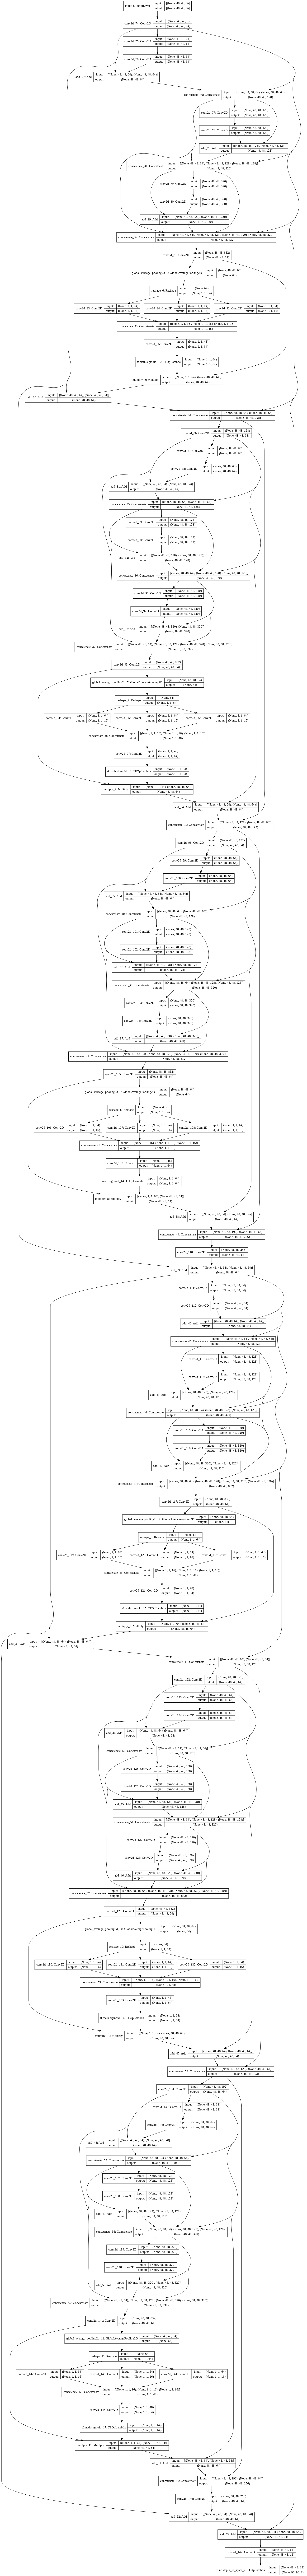

In [ ]:
def Laplacian_attention(input,filters_num=64):
  x1=tf.keras.layers.GlobalAveragePooling2D()(input)
  x1=tf.keras.layers.Reshape((1,1,filters_num))(x1)
  x2=tf.keras.layers.Conv2D(filters=filters_num/4,kernel_size=1,activation='relu',dilation_rate=(7,7))(x1)
  x3=tf.keras.layers.Conv2D(filters=filters_num/4,kernel_size=1,activation='relu',dilation_rate=(5,5))(x1)
  x4=tf.keras.layers.Conv2D(filters=filters_num/4,kernel_size=1,activation='relu',dilation_rate=(3,3))(x1)
  x5=tf.keras.layers.concatenate([x2,x3,x4])
  x6=tf.keras.layers.Conv2D(filters=filters_num,kernel_size=1)(x5)
  x6=tf.keras.activations.sigmoid(x6)
  x7=tf.keras.layers.multiply([x6,input])
  return x7


def DRLM(input,filters_num=64,filter_size=3):

  x1=tf.keras.layers.Conv2D(filters=filters_num,kernel_size=filter_size,activation='relu',padding="same")(input)
  x2=tf.keras.layers.Conv2D(filters=filters_num,kernel_size=filter_size,activation='relu',padding="same")(x1)
  x3=tf.keras.layers.Add()([input,x2])
  x4=tf.keras.layers.concatenate([input, x3])

  x5=tf.keras.layers.Conv2D(filters=filters_num*2,kernel_size=filter_size,activation='relu',padding="same")(x4)
  x6=tf.keras.layers.Conv2D(filters=filters_num*2,kernel_size=filter_size,activation='relu',padding="same")(x5)
  x7=tf.keras.layers.Add()([x6, x4])
  x8=tf.keras.layers.concatenate([input,x4,x7])

  x9=tf.keras.layers.Conv2D(filters=filters_num*5,kernel_size=filter_size,activation='relu',padding="same")(x8)
  x10=tf.keras.layers.Conv2D(filters=filters_num*5,kernel_size=filter_size,activation='relu',padding="same")(x9)
  x11=tf.keras.layers.Add()([x8, x10])
  x12=tf.keras.layers.concatenate([input,x4,x8,x11])

  x13=tf.keras.layers.Conv2D(filters=filters_num,kernel_size=1)(x12)  #compression unit
  x14=Laplacian_attention(x13,filters_num=filters_num)
  x15=tf.keras.layers.Add()([x14,input])
  return x15

def cas_block(input,filters_num=64,filter_size=3,num_of_DRLM=3):
  main_input=input
  x1=DRLM(input,filters_num,filter_size)
  for i in range(num_of_DRLM-1):
    x2=tf.keras.layers.concatenate([x1,input])
    x1=x2
    x3=tf.keras.layers.Conv2D(filters=filters_num,kernel_size=filter_size,activation='relu',padding="same")(x2)
    x4=DRLM(x3,filters_num,filter_size)
    input=x4
  x2=tf.keras.layers.concatenate([x1,input])
  x3=tf.keras.layers.Conv2D(filters=filters_num,kernel_size=filter_size,activation='relu',padding="same")(x2)
  x4=tf.keras.layers.Add()([main_input, x3])
  return x4

def get_CRIR_model(input_shape=(48,48,3),upscale_factor=2,num_output_channels=3,filters_num=64,filter_size=3,num_of_DRLM=3,num_of_cas_blocks=2):
  
  x1=tf.keras.layers.Input(shape=input_shape)
  x2=tf.keras.layers.Conv2D(filters=filters_num,kernel_size=filter_size,activation='relu',padding="same")(x1)
  x3=x2
  for i in range(num_of_cas_blocks):   
    x3=cas_block(x3,filters_num=filters_num,filter_size=filter_size)
  x4=tf.keras.layers.Add()([x2, x3])
  x4=tf.keras.layers.Conv2D(num_output_channels * (upscale_factor ** 2),kernel_size=filter_size,activation='relu',padding="same")(x4)
  outputs = tf.nn.depth_to_space(x4, upscale_factor)
  return tf.keras.Model(x1, outputs)
def get_new_CRIR_model(input_shape=(48,48,3),upscale_factor=2,num_output_channels=3,filters_num=64,filter_size=3,num_of_DRLM=3,num_of_cas_blocks=2):
  x1=tf.keras.layers.Input(shape=input_shape)
  x2=tf.keras.layers.Conv2D(filters=filters_num,kernel_size=filter_size,activation='relu',padding="same")(x1)
  x3=x2
  for i in range(num_of_cas_blocks):   
    x3=cas_block(x3,filters_num=filters_num,filter_size=filter_size)
  x4=tf.keras.layers.Add()([x2, x3])
  x4=tf.keras.layers.Conv2D(num_output_channels ,kernel_size=filter_size,activation='relu',padding="same")(x4)

  return tf.keras.Model(x1, x4)  

model =get_CRIR_model()

print(len(model.layers))
tf.keras.utils.plot_model(model, show_shapes=True,rankdir='LB')




In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
vgg_model = VGG19(include_top=False,weights='imagenet')
vgg_model.trainable=False
class VggFeaturesExtractor:
    def __init__(self ):
        self.layers = [2,5,10,15,20,21,-2]
        from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
        vgg_model = VGG19(include_top=False)
        self.preprocess_input = preprocess_input

        outputs = []
        for layer_num in self.layers:
            outputs.append(vgg_model.layers[layer_num].output)
        self.feature_extractor = tf.keras.Model(inputs=vgg_model.input, outputs=outputs)

    def extract_features(self, images: np.ndarray):
        preprocessed_images = self.preprocess_input(images)
        features = self.feature_extractor(preprocessed_images)
        return features
vgg_feature_extractor=VggFeaturesExtractor()
def vgg_loss( gt_image, est_image):
    gt_features = vgg_feature_extractor.extract_features(gt_image)
    est_features =vgg_feature_extractor.extract_features(est_image)
    error = gt_image-est_image    
    sqr_error = K.square(error)
    MSE = K.mean(sqr_error)

    loss = tf.reduce_mean(tf.square(gt_features[0] - est_features[0])) + \
           tf.reduce_mean(tf.square(gt_features[1] - est_features[1])) + \
           tf.reduce_mean(tf.square(gt_features[2] - est_features[2]))
    ssim_=1-ssim(gt_image,est_image)
    out=loss/350+MSE+ssim_
    return out

In [ ]:
def ssim( gt_image, est_image):
  out=tf.image.ssim(gt_image, est_image,max_val=1)

  return out
def psnr( gt_image, est_image):
  out=tf.image.psnr(gt_image, est_image,max_val=1)
  return out

In [ ]:
def tf_count(t, val):
    elements_equal_to_value = tf.equal(t, val)
    as_ints = tf.cast(elements_equal_to_value, tf.int32)
    count = tf.reduce_sum(as_ints)
    return count
    
def hf_loss( gt_image, est_image):

    V1=.45
    gt=tf.math.round(gt_image*255)
    est=tf.math.round(est_image*255)
    Gz=tf_count(gt,0)
    Bz=tf_count(est,0)
    
    N=K.abs(Gz-Bz)/(K.abs(Gz+Bz)+1)
    loss=N*V1
    
    return loss

In [ ]:

def get_hf_tf(img):

  sobel_x=np.array([[1,0,-1],[2,0,-2],[1,0,-1]],dtype=np.float32)
  sobel_x=tf.expand_dims(sobel_x, 0)
  sobel_x=tf.expand_dims(sobel_x, 0)
  sobel_y=np.array([[1,2,1],[0,0,0],[-1,-2,-1]],dtype=np.float32)
  sobel_y=tf.expand_dims(sobel_y, 0)
  sobel_y=tf.expand_dims(sobel_y, 0)
  in_x =tf.nn.conv2d(img, sobel_x, strides=[1, 1, 1, 1], padding='SAME') 
  in_y =tf.nn.conv2d(img, sobel_y, strides=[1, 1, 1, 1], padding='SAME')
  out=tf.add(tf.pow(in_x,2),tf.pow(in_y,2))
  out=tf.pow(out,.5)
  tf.squeeze(out)
  return out

def MIOU_loss( gt_image, est_image):


    hf_gt=get_hf_tf(gt_image)
    hf_est=get_hf_tf(est_image)
    loss_hf=hf_loss(hf_gt,hf_est)
    pre_loss=vgg_loss(gt_image,est_image)/3
    pre_loss=tf.cast(pre_loss,tf.float64)
    out=tf.squeeze(pre_loss)+loss_hf
    return out
def hf_hf_loss( gt_image, est_image):


    hf_gt=get_hf_tf(gt_image)
    hf_est=get_hf_tf(est_image)
    loss_hf=hf_loss(hf_gt,hf_est)*4
    mse=tf.keras.losses.mse(gt_image,est_image)/10
    out=tf.cast(mse,tf.float64)+loss_hf
    return out

In [ ]:
def noisy(noise_typ,image):
  if noise_typ == 0:

      row,col,ch= image.shape
      mean = 0
      var = 12
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy
  elif noise_typ == 1:

      row,col,ch = image.shape
      s_vs_p = 0.5
      amount = 0.005
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
      out[coords] = 1

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
      out[coords] = 0
      return out




In [ ]:
class DataGen(tf.keras.utils.Sequence):
    
    def __init__(self, paths,
                 batch_size,
                 input_image_size,
                 output_image_size,
                 cut_frequecny=1,
                 out_type='image',
                 muilt_input=True,
                 ):
       
        self.paths = paths[:]
        for i in range(2):
          self.paths.extend(self.paths)
        self.batch_size = batch_size
        self.input_image_size = input_image_size
        self.output_image_size = output_image_size
        self.cut_frequecny=cut_frequecny
        self.out_type=out_type
        self.muilt_input=muilt_input
        self.n = len(self.paths)

    def __get_hf(self,image):
      sobel_x=np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
      sobel_y=np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
      image=np.array(image,dtype=np.float64)
      image_x = cv2.filter2D(image, cv2.CV_64F, sobel_x)
      image_y = cv2.filter2D(image, cv2.CV_64F, sobel_y)
      out=self.cut_frequecny*((image_x**2+image_y**2)**.5)
      return out

    def __get_in_out(self, path):

        pad_nopad=randint(0,100)        
        HR_im_path=path
        output_image_size=self.output_image_size


        Zoom_Alg=[cv2.INTER_NEAREST,
                  cv2.INTER_AREA,
                  cv2.INTER_CUBIC,
                  cv2.INTER_LANCZOS4,
                  cv2.INTER_LINEAR,
        ]
        alg_type=randint(0,4)



        image_HR_arr=np.asarray(Image.open(HR_im_path))

        shape_HR=image_HR_arr.shape
        start_x=randint(0,shape_HR[0]-output_image_size)
        start_y=randint(0,shape_HR[1]-output_image_size) 
        out_=image_HR_arr[start_x:start_x+output_image_size,start_y:start_y+output_image_size]
        
        if pad_nopad<5:
          r_x=randint(np.int(output_image_size/3),output_image_size-1)
          r_y=randint(np.int(output_image_size/3),output_image_size-1)
          out_=np.array(out_)
          c=[randint(0,255),randint(0,255),randint(0,255)]
          out_[r_x:,r_y:]=c

    
        in_=cv2.resize(out_, dsize=(self.input_image_size,self.input_image_size), interpolation=Zoom_Alg[alg_type])

        if pad_nopad<33 :
          pass
        elif pad_nopad<65 :
          in_=np.fliplr(in_)
          out_=np.fliplr(out_)
        elif pad_nopad <93:
          in_=np.flipud(in_)
          out_=np.flipud(out_)
        elif pad_nopad <96:
          in_=tf.image.adjust_jpeg_quality(in_, randint(50,85))

        else:
          in_=noisy(randint(0,1),in_)

        in_=in_/255
        out_=out_/255
        

        if self.muilt_input==False:
          if self.out_type=='image':
            return in_,out_

          elif self.out_type=='HF':
            return self.__get_hf(in_),self.__get_hf(out_)
          elif self.out_type=='LF':
            return in_-self.__get_hf(in_),out_-self.__get_hf(out_)
          else:
            raise Exception('out_type is not supperted')


        else:
            in_hf= self.__get_hf(in_)
            in_lf=in_-in_hf           

            return in_hf,in_lf,out_

    def __get_data(self, batches):
        if self.muilt_input==True:    
          x_1_batch=np.empty((self.batch_size,self.input_image_size,self.input_image_size,3))
          x_2_batch=np.empty((self.batch_size,self.input_image_size,self.input_image_size,3))
          y_batch=np.empty((self.batch_size,self.output_image_size,self.output_image_size,3))
          for id,path  in enumerate(batches):
            x1,x2,y=self.__get_in_out(path)
            x_1_batch[id,]=x1
            x_2_batch[id,]=x2
            y_batch[id,]=y
          return [x_1_batch,x_2_batch],y_batch

        else:
          x_batch=np.empty((self.batch_size,self.input_image_size,self.input_image_size,3))
          y_batch=np.empty((self.batch_size,self.output_image_size,self.output_image_size,3))         
          for id,path  in enumerate(batches):
            x,y=self.__get_in_out(path)
            x_batch[id,]=x
            y_batch[id,]=y
          return x_batch,y_batch
        
    
    def __getitem__(self, index):
        
        batches = self.paths[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)  
        return X,y
    
    def __len__(self):
        return self.n // self.batch_size


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rot 90


Text(0.5, 1.0, 'hf_lR')

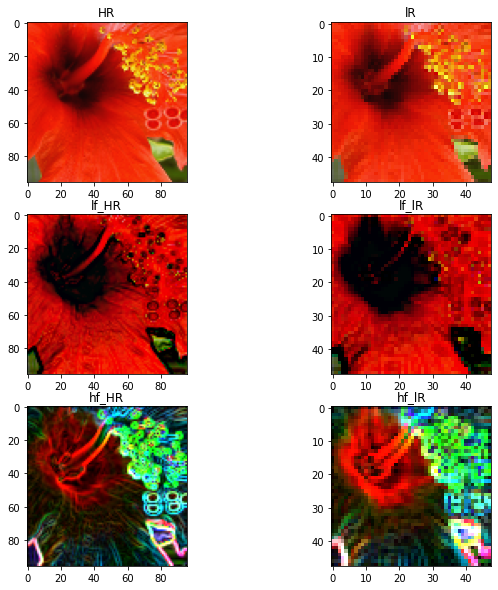

In [ ]:

def get_hf(img):
  sobel_x=np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
  sobel_y=np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
  img=np.array(img,dtype=np.float64)
  in_x = cv2.filter2D(img, cv2.CV_64F, sobel_x)
  in_y = cv2.filter2D(img, cv2.CV_64F, sobel_y)
  out=(in_x**2+in_y**2)**.5
  return out

HR_im_path='/content/drive/MyDrive/HR_images/section8-image.png'

pad_nopad=randint(0,100)        
output_image_size=96


Zoom_Alg=[cv2.INTER_NEAREST,
          cv2.INTER_AREA,
          cv2.INTER_CUBIC,
          cv2.INTER_LANCZOS4,
          cv2.INTER_LINEAR,
]
alg_type=randint(0,4)
print(alg_type)


image_HR_arr=np.asarray(Image.open(HR_im_path))

shape_HR=np.array(image_HR_arr.shape)
start_x=randint(0,shape_HR[0]-output_image_size)
start_y=randint(0,shape_HR[1]-output_image_size) 
out_=image_HR_arr[start_x:start_x+output_image_size,start_y:start_y+output_image_size]
if pad_nopad<6:
  print("hide a part")
  r_x=randint(output_image_size/3,output_image_size-1)
  r_y=randint(output_image_size/3,output_image_size-1)
  out_=np.array(out_)
  c=[randint(0,255),randint(0,255),randint(0,255)]
  out_[r_x:,r_y:]=c

in_=cv2.resize(out_, dsize=(48,48), interpolation=Zoom_Alg[alg_type])
if pad_nopad<53 :
  print("no change")
  pass
elif pad_nopad<93 :
  print("rot 90")
  in_=np.rot90(in_)
  out_=np.rot90(out_)
elif pad_nopad <96:
  print("jpeg effect")
  in_=tf.image.adjust_jpeg_quality(in_, randint(50,85))


else:
  noise_type=randint(0,1)
  print(noise_type)
  if noise_type==0:
    print("gauss noise")
  else:
    print("S & B")
  in_=noisy(noise_type,in_)


in_=in_/255
out_=out_/255
HR_HF=get_hf(out_)
HR_LF=out_-HR_HF
LR_HF=get_hf(in_)
LR_LF=in_-LR_HF




fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(3, 2, 1)
imgplot = plt.imshow(out_)
ax.set_title('HR')

ax = fig.add_subplot(3, 2,2)
imgplot = plt.imshow(in_)
ax.set_title('lR')

ax = fig.add_subplot(3, 2, 3)
imgplot = plt.imshow(HR_LF)
ax.set_title('lf_HR')

ax = fig.add_subplot(3, 2,4)
imgplot = plt.imshow(LR_LF)
ax.set_title('lf_lR')

ax = fig.add_subplot(3, 2, 5)
imgplot = plt.imshow(HR_HF)
ax.set_title('hf_HR')

ax = fig.add_subplot(3, 2,6)
imgplot = plt.imshow(LR_HF)
ax.set_title('hf_lR')


In [ ]:
!unzip /content/drive/MyDrive/HR_images/DIV2K/DIV2K_train_HR.zip -d /content
!unzip /content/drive/MyDrive/HR_images/DIV2K/DIV2K_valid_HR.zip -d /content
!unzip /content/drive/MyDrive/HR_images/Flickr2K/Flickr2K.zip -d /content
!unzip /content/drive/MyDrive/HR_images/manga109.zip -d /content

train_dir = "/content/DIV2K_train_HR"
test_dir = "/content/DIV2K_valid_HR"
train_2k_dir = "/content/Flickr2K"
train_manga_dir = "/content/manga109"

train_paths = [os.path.join(train_dir,f) for f in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, f))]
test_paths = [os.path.join(test_dir,f) for f in os.listdir(test_dir) if os.path.isfile(os.path.join(test_dir, f))]
train_2k_paths = [os.path.join(train_2k_dir,f) for f in os.listdir(train_2k_dir) if os.path.isfile(os.path.join(train_2k_dir, f))]
train_manga_paths = [os.path.join(train_manga_dir,f) for f in os.listdir(Ntrain_manga_dir) if os.path.isfile(os.path.join(train_manga_dir, f))]

train_paths.extend(train_2k_paths)
hf_train_paths=train_paths[:]
hf_train_paths.extend(train_manga_paths)


Archive:  /content/drive/MyDrive/HR_images/DIV2K/DIV2K_train_HR.zip
replace /content/DIV2K_train_HR/0103.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/drive/MyDrive/HR_images/DIV2K/DIV2K_valid_HR.zip
replace /content/DIV2K_valid_HR/0897.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/drive/MyDrive/HR_images/Flickr2K/Flickr2K.zip
replace /content/Flickr2K/000001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N
Archive:  /content/drive/MyDrive/HR_images/manga109.zip
replace /content/manga109/ARMS.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
آNbatch_size=16
input_image_size=48
output_image_size=96
img_img_gen_N_train=DataGen(paths=hf_train_paths,batch_size=batch_size,input_image_size=input_image_size,
                          output_image_size=output_image_size,
                          muilt_input=False)
img_img_gen_test=DataGen(paths=test_paths,batch_size=batch_size,input_image_size=input_image_size,
                          output_image_size=output_image_size,
                          muilt_input=False)


img_img_model_N_path='/content/drive/MyDrive/img_img_model_N'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=img_img_model_N_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
img_img_model_N = tf.keras.models.load_model('/content/drive/MyDrive/img_img_model_N',custom_objects={'vgg_loss':vgg_loss,'ssim':ssim,'psnr':psnr,'MIOU_loss':MIOU_loss})

#img_img_model_N=get_CRIR_model()
img_img_model_N.compile(optimizer='adam',loss=MIOU_loss,metrics=[ssim,psnr,'mse',vgg_loss])
history_img_img=img_img_model_N.fit(img_img_gen_N_train,validation_data=img_img_gen_test,validation_freq=1,epochs=6,callbacks=checkpoint)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Epoch 1/6
889/889 [==============================] - 1813s 2s/step - loss: 0.2360 - ssim: 0.8873 - psnr: 30.6084 - mse: 0.0019 - vgg_loss: 0.1307 - val_loss: 0.2226 - val_ssim: 0.8818 - val_psnr: 31.4156 - val_mse: 0.0018 - val_vgg_loss: 0.1345

Epoch 00001: val_loss improved from inf to 0.22262, saving model to /content/drive/MyDrive/img_img_model_N


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/img_img_model_N/assets
Epoch 2/6
  1/889 [..............................] - ETA: 34:58 - loss: 0.3288 - ssim: 0.9051 - psnr: 31.5656 - mse: 0.0022 - vgg_loss: 0.1156

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


889/889 [==============================] - 1746s 2s/step - loss: 0.2287 - ssim: 0.8943 - psnr: 30.9330 - mse: 0.0018 - vgg_loss: 0.1228 - val_loss: 0.1330 - val_ssim: 0.8961 - val_psnr: 31.7784 - val_mse: 0.0015 - val_vgg_loss: 0.1192

Epoch 00002: val_loss improved from 0.22262 to 0.13303, saving model to /content/drive/MyDrive/img_img_model_N


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/img_img_model_N/assets
Epoch 3/6
  4/889 [..............................] - ETA: 28:12 - loss: 0.1858 - ssim: 0.8774 - psnr: 30.0659 - mse: 0.0019 - vgg_loss: 0.1369

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


889/889 [==============================] - 1756s 2s/step - loss: 0.2260 - ssim: 0.8969 - psnr: 30.7921 - mse: 0.0018 - vgg_loss: 0.1197 - val_loss: 0.1975 - val_ssim: 0.8792 - val_psnr: 27.2350 - val_mse: 0.0028 - val_vgg_loss: 0.1376

Epoch 00003: val_loss did not improve from 0.13303
Epoch 4/6
889/889 [==============================] - 1765s 2s/step - loss: 0.2235 - ssim: 0.8967 - psnr: 31.0048 - mse: 0.0018 - vgg_loss: 0.1205 - val_loss: 0.1931 - val_ssim: 0.8800 - val_psnr: 31.2873 - val_mse: 0.0016 - val_vgg_loss: 0.1332

Epoch 00004: val_loss did not improve from 0.13303
Epoch 5/6
889/889 [==============================] - 1769s 2s/step - loss: 0.2248 - ssim: 0.8982 - psnr: 31.1550 - mse: 0.0018 - vgg_loss: 0.1183 - val_loss: 0.1917 - val_ssim: 0.8889 - val_psnr: 31.2500 - val_mse: 0.0017 - val_vgg_loss: 0.1271

Epoch 00005: val_loss did not improve from 0.13303
Epoch 6/6
889/889 [==============================] - 1773s 2s/step - loss: 0.2318 - ssim: 0.8986 - psnr: 31.0294 - mse: